In [22]:
library(hydra)
library(ape)
library(MASS)
library(stringr)

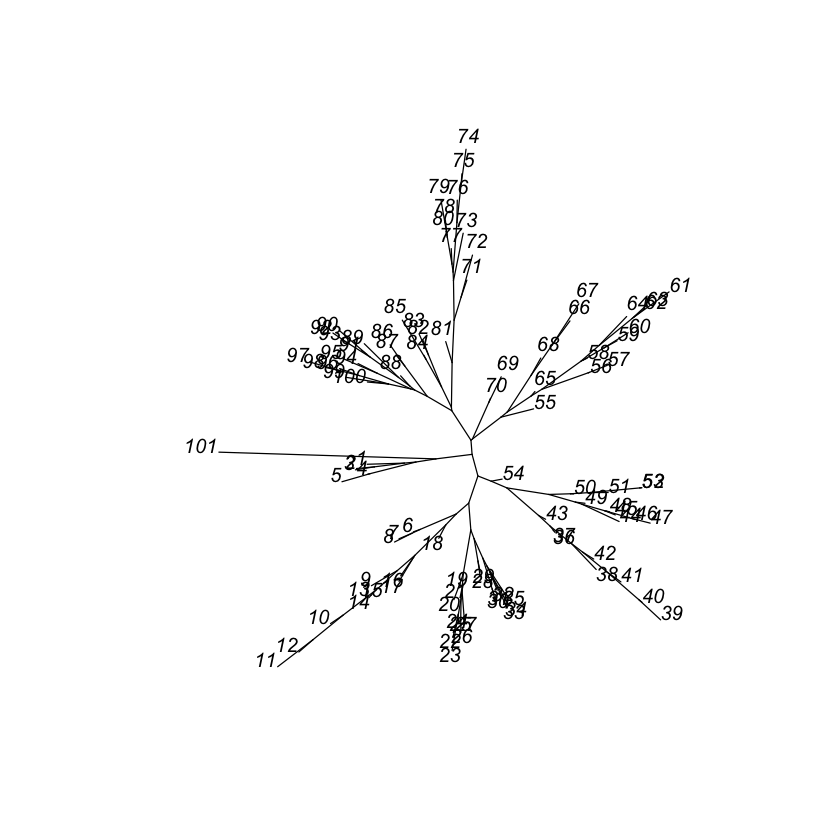

In [23]:
#generate simulation tree

Nleaves <- 100
alpha <- 0.5

tree <- rtree(Nleaves)
tree$tip.label <- 1:Nleaves
for(j in 1:length(tree$edge.length)){
    tree$edge.length[j] <- alpha * (1 - log(runif(1)*(exp(1)-1)+1))
}

tmp <- paste("(",str_sub(write.tree(tree), end=-2),":0.1,",Nleaves+1,":2);",sep="")
tree <- read.tree(text=tmp)

plot(tree, type="unrooted")

In [28]:
#geodesic distance on Poincare ball
Poincare_dist <- function(u,v){
    if(sum(u**2)>=1 || sum(v**2)>=1){
        return(Inf)
    }else{
        return(acosh(1+2*(sum((u-v)**2))/(1-sum(u**2))/(1-sum(v**2))))
    }
}

#embedding dimension
Ms <- c(5,10,20,30)

Nleaves <- length(tree$tip.label)
tree$mrca <- mrca(tree)
D <- dist.nodes(tree)

Nall <- dim(D)[1]
X1 <- D
X2 <- acosh(exp(D))

MSE_H1 <- rep(0, length(Ms))
MSE_H2 <- rep(0, length(Ms))
MSE_MDS <- rep(0, length(Ms))

angle_H1 <- matrix(0, Nleaves*(Nleaves-1)/2, length(Ms))
angle_H2 <- matrix(0, Nleaves*(Nleaves-1)/2, length(Ms))
angle_MDS <- matrix(0, Nleaves*(Nleaves-1)/2, length(Ms))

for(M in Ms){
    #general hyperbolic embeddings
    X1.hydra <- hydraPlus(X1, dim=M, curvature=1, alpha=1, equi.adj=0, control=list(return.dist=1, isotropic.adj=FALSE))
    Z1 <- X1.hydra$r * X1.hydra$directional
    X1.hydra$dist <- hydra:::get.distance(X1.hydra$r, X1.hydra$directional, X1.hydra$curvature)
    
    #our hyperbolic embeddings
    X2.hydra <- hydraPlus(X2, dim=M, curvature=1, alpha=1, equi.adj=0, control=list(return.dist=1, isotropic.adj=FALSE))
    Z2 <- X2.hydra$r * X2.hydra$directional
    X2.hydra$dist <- hydra:::get.distance(X2.hydra$r, X2.hydra$directional, X2.hydra$curvature)

    #Euclidean embeddings
    X1.mds <- sammon(X1, k=M)
    X1.mds$dist <- matrix(0, Nall, Nall)
    for(i in 1:Nall){
        for(j in 1:Nall){
            X1.mds$dist[i,j] <- sqrt(sum((X1.mds$points[i,]-X1.mds$points[j,])**2))
        }
    }

    #MSE
    MSE_H1[which(Ms==M)] <- sum((c(D[upper.tri(D)])-c(X1.hydra$dist[upper.tri(D)]))**2) / choose(Nall,2)
    MSE_H2[which(Ms==M)] <- sum((c(D[upper.tri(D)])-c(log(cosh(X2.hydra$dist[upper.tri(D)]))))**2) / choose(Nall,2)
    MSE_MDS[which(Ms==M)] <- sum((c(D[upper.tri(D)])-c(X1.mds$dist[upper.tri(D)]))**2) / choose(Nall,2)
    
    #Angle information
    idx <- 1
    for(i in 1:(Nleaves-1)){
        for(j in (i+1):Nleaves){
            k <- tree$mrca[i,j]
            
            #general hyperbolic embeddings
            a <- Poincare_dist(Z1[i,], Z1[k,])
            b <- Poincare_dist(Z1[j,], Z1[k,])
            c <- Poincare_dist(Z1[i,], Z1[j,])
            angle_H1[idx,which(Ms==M)] <- acos((cosh(a)*cosh(b)-cosh(c))/(sinh(a)*sinh(b)))
            
            #our hyperbolic embeddings
            a <- Poincare_dist(Z2[i,], Z2[k,])
            b <- Poincare_dist(Z2[j,], Z2[k,])
            c <- Poincare_dist(Z2[i,], Z2[j,])
            angle_H2[idx,which(Ms==M)] <- acos((cosh(a)*cosh(b)-cosh(c))/(sinh(a)*sinh(b)))
            
            #Euclidean embeddings
            a <- sqrt(sum((X1.mds$points[i,]-X1.mds$points[k,])**2))
            b <- sqrt(sum((X1.mds$points[j,]-X1.mds$points[k,])**2))
            c <- sqrt(sum((X1.mds$points[i,]-X1.mds$points[j,])**2))
            angle_MDS[idx,which(Ms==M)] <- acos((a**2+b**2-c**2)/(2*a*b))
            idx <- idx + 1
        }
    }
}

iter   10 value 469.924124
iter   20 value 359.854851
iter   30 value 337.300439
iter   40 value 326.905996
iter   50 value 321.835280
iter   60 value 319.830972
iter   70 value 318.984499
iter   80 value 318.574085
iter   90 value 318.380862
iter  100 value 318.223363
iter  110 value 318.079644
iter  120 value 317.845873
iter  130 value 317.715524
iter  140 value 317.677117
iter  150 value 317.659520
iter  160 value 317.644190
iter  170 value 317.622592
iter  180 value 317.598102
iter  190 value 317.579651
iter  200 value 317.561339
iter  210 value 317.548942
iter  220 value 317.542109
iter  230 value 317.537877
iter  240 value 317.535162
iter  250 value 317.533473
iter  260 value 317.532457
iter  270 value 317.531854
iter  280 value 317.531481
iter  290 value 317.531134
iter  300 value 317.530904
iter  310 value 317.530726
iter  320 value 317.530597
iter  330 value 317.530516
iter  340 value 317.530455
iter  350 value 317.530404
iter  360 value 317.530371
final  value 317.530365 
con

In [29]:
#MSE
result <- rbind(MSE_MDS, MSE_H1, MSE_H2)
colnames(result) <- Ms
rownames(result) <- c("MDS","H1", "H2")
result

,5,10,20,30
MDS,0.22843070,0.045991711,0.0248239345,0.0252232623
H1,0.01579753,0.004016482,0.0030248625,0.0029884050
H2,0.02509713,0.003704609,0.0004400514,0.0001204638


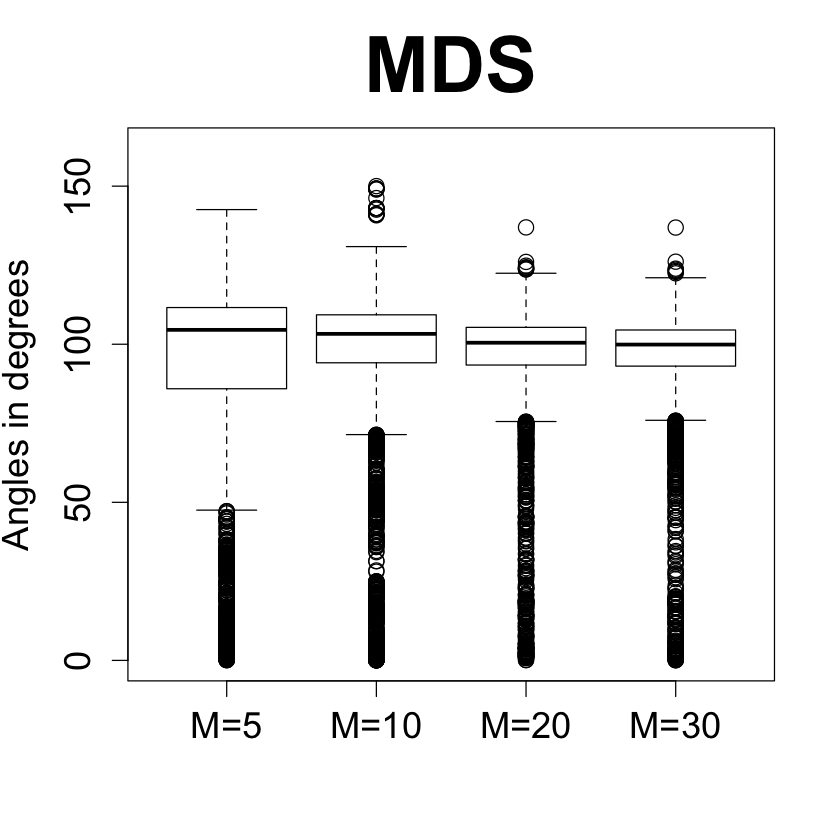

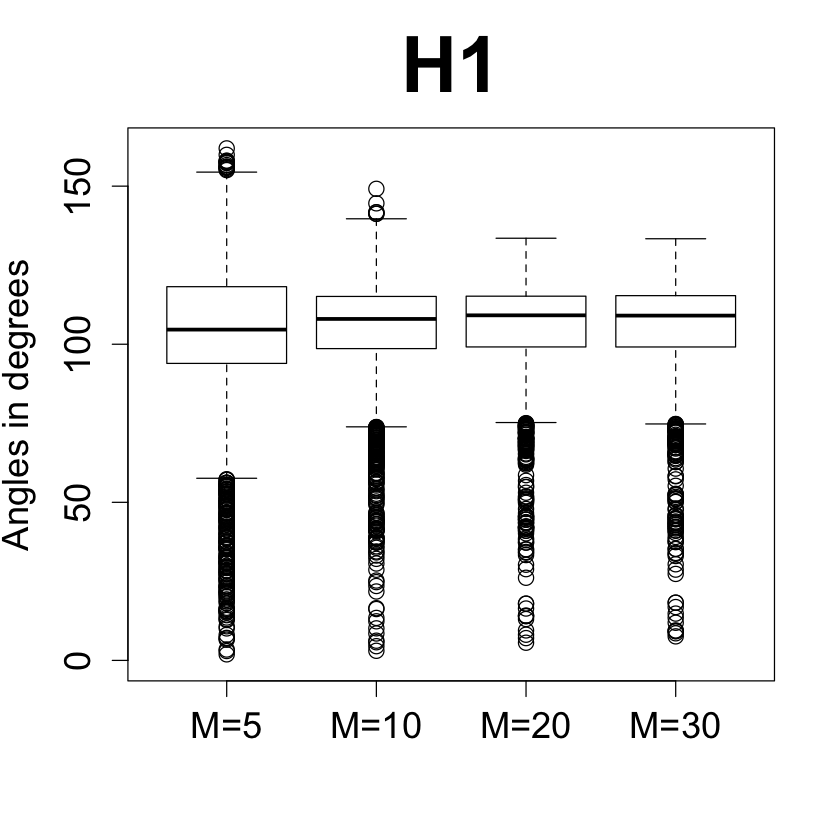

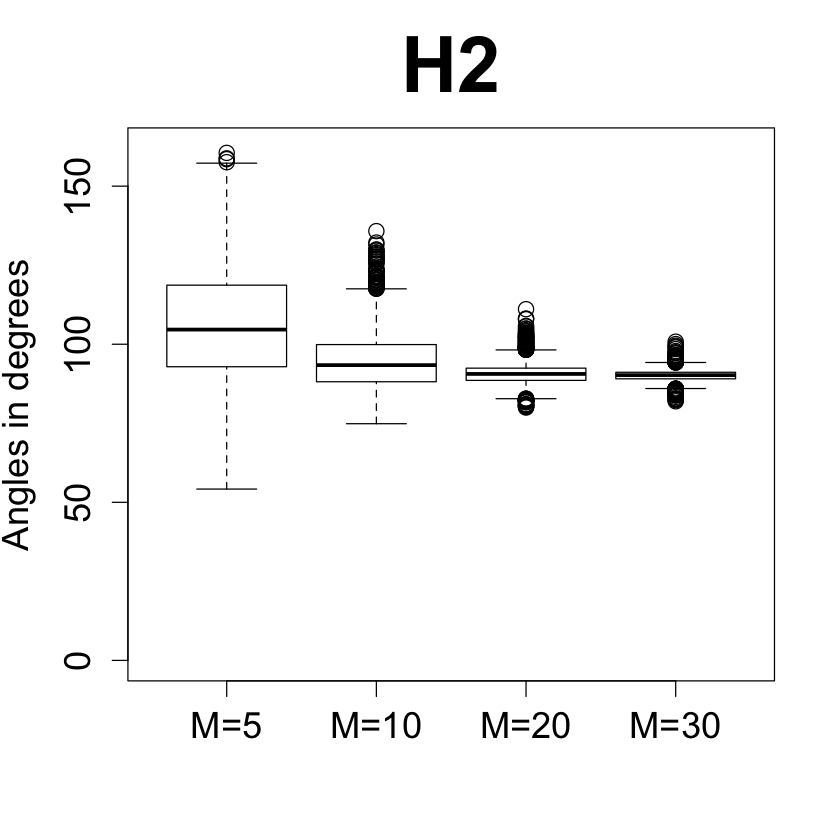

In [30]:
#Angle
yrange <- c(0, max(max(angle_H1/(2*pi)*360),max(angle_H2/(2*pi)*360)))
par(cex=1.3)
tmp <- angle_MDS/(2*pi)*360
tmp2 <- list("M=5"=tmp[,1],"M=10"=tmp[,2],"M=20"=tmp[,3],"M=30"=tmp[,4])
boxplot(tmp2, ylim=yrange, ylab="Angles in degrees", main="MDS", cex.lab=1.4, cex.axis=1.4, cex.main=3)

tmp <- angle_H1/(2*pi)*360
tmp2 <- list("M=5"=tmp[,1],"M=10"=tmp[,2],"M=20"=tmp[,3],"M=30"=tmp[,4])
boxplot(tmp2, ylim=yrange, ylab="Angles in degrees", main="H1", cex.lab=1.4, cex.axis=1.4, cex.main=3)

tmp <- angle_H2/(2*pi)*360
tmp2 <- list("M=5"=tmp[,1],"M=10"=tmp[,2],"M=20"=tmp[,3],"M=30"=tmp[,4])
boxplot(tmp2, ylim=yrange, ylab="Angles in degrees", main="H2", cex.lab=1.4, cex.axis=1.4, cex.main=3)